In [1]:
import sys 
sys.path.append('src')

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
# from quantum_circuit import q_net, Quantumnet
from quantum_circuit import build_qnode, Quantumnet
import pennylane as qml

# Other tools
import time
import os
import copy

# Modular
from dataset import get_data_transforms, get_dataloaders
from utils import imshow, plot_tensorboard_metric
from training import train_model, save_model, load_model, visualize_model


env: OMP_NUM_THREADS=1


In [ ]:
base_model = 'vgg16'
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                     # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 25                  # Number of training epochs
# q_depth = 6                      # Depth of the quantum circuit (number of variational layers)
q_depth = 6
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [136]:
# Quantum device - PennyLane
dev = qml.device('default.qubit', wires=n_qubits)
# Classical device - GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
print(torch.cuda.get_device_name(0))

✅ Usando dispositivo: cuda:0
NVIDIA GeForce RTX 4070 Laptop GPU


In [137]:
data_dir = 'CremaD/mel_spec_reduced_HAP_SAD'

# data_transforms = get_data_transforms()

torch.manual_seed(rng_seed)

dataloaders, dataset_sizes, class_names = get_dataloaders(
    data_dir=data_dir, batch_size=batch_size, shuffle=True, spec_augment=True
)

# image_datasets = {
#     x: dataloaders[x].dataset for x in ['train', 'val']
# }

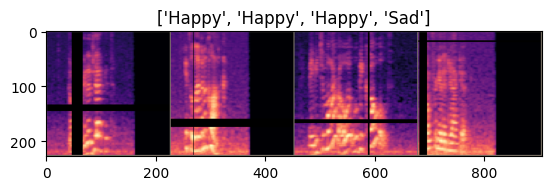

In [138]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if base_model == 'resnet18':
    model_hybrid = torchvision.models.resnet18(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.fc = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=2
        )

    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, 3)
        
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 3)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 3))

elif base_model == 'vgg16':
    model_hybrid = torchvision.models.vgg16(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.classifier[6] = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=2
        )

    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, 2)
        
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# model_hybrid = torchvision.models.resnet18(pretrained=True)
# model_hybrid = torchvision.models.vgg16(pretrained=True)

# for param in model_hybrid.parameters():
#     param.requires_grad = False
    
# if quantum:
#     # model_hybrid.fc = Quantumnet(
#     #     n_qubits=n_qubits,
#     #     q_depth=q_depth,
#     #     max_layers=max_layers,
#     #     q_delta=q_delta,
#     #     dev=dev, 
#     #     n_classes=3
#     # )
#     model_hybrid.classifier[6] = Quantumnet(
#         n_qubits=n_qubits,
#         q_depth=q_depth,
#         max_layers=max_layers,
#         q_delta=q_delta,
#         dev=dev, 
#         n_classes=2
#     )
    
# elif classical_model == '512_2':
#     model_hybrid.fc = nn.Linear(512, 3)
    
# elif classical_model == '512_nq_2':
#     model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 3)) 

# elif classical_model == '551_512_2':
#     model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 3))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [140]:
# Definición de la función de pérdida (loss)
criterion = nn.CrossEntropyLoss()

# Definición del optimizador
# optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
optimizer_hybrid = optim.Adam(model_hybrid.classifier[6].parameters(), lr=step)

# Definición del scheduler para reducir el learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=5, gamma=gamma_lr_scheduler)


In [141]:
prefix = "q" if quantum else "cl"
timestamp = time.strftime('%Y%m%d_%H%M%S')
log_name = f"{prefix}_emotions_vgg16_{timestamp}_final"
print(log_name)

writer = SummaryWriter(log_dir=f"runs/{log_name}")

model_hybrid = train_model(
    model=model_hybrid,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs, 
    writer=writer
)
writer.close()

q_emotions_vgg16_20250524_150632_final
🚀 Training started:
Phase: train Epoch: 1/25 Loss: 0.6677 Acc: 0.5987: 0.0499s
Phase: val Epoch: 1/25 Loss: 0.6049 Acc: 0.7425: 0.0291s
Phase: train Epoch: 2/25 Loss: 0.5586 Acc: 0.7269: 0.0478s
Phase: val Epoch: 2/25 Loss: 0.4650 Acc: 0.8169: 0.0306s
Phase: train Epoch: 3/25 Loss: 0.5218 Acc: 0.7637: 0.0519s
Phase: val Epoch: 3/25 Loss: 0.5201 Acc: 0.7565: 0.0292s
Phase: train Epoch: 4/25 Loss: 0.5153 Acc: 0.7670: 0.0584s
Phase: val Epoch: 4/25 Loss: 0.5167 Acc: 0.7827: 0.0324s
Phase: train Epoch: 5/25 Loss: 0.5050 Acc: 0.7737: 0.0468s
Phase: val Epoch: 5/25 Loss: 0.4710 Acc: 0.8028: 0.0311s
Phase: train Epoch: 6/25 Loss: 0.4796 Acc: 0.8004: 0.0505s
Phase: val Epoch: 6/25 Loss: 0.4229 Acc: 0.8370: 0.0274s
Phase: train Epoch: 7/25 Loss: 0.4759 Acc: 0.7882: 0.0504s
Phase: val Epoch: 7/25 Loss: 0.4062 Acc: 0.8531: 0.0293s
Phase: train Epoch: 8/25 Loss: 0.4736 Acc: 0.8027: 0.0561s
Phase: val Epoch: 8/25 Loss: 0.4065 Acc: 0.8491: 0.0269s
Phase: train 

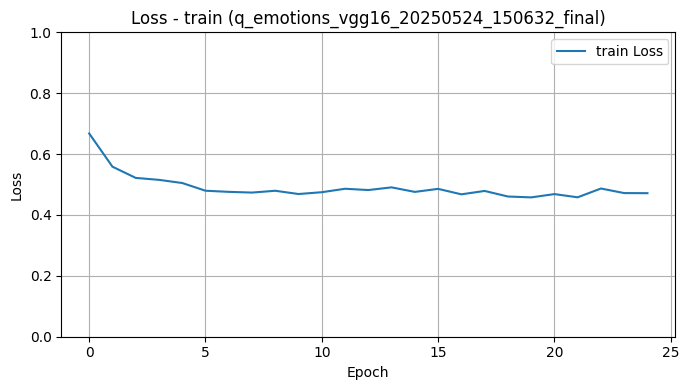

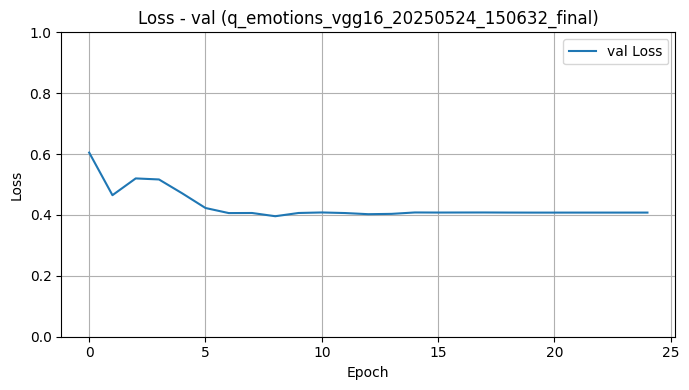

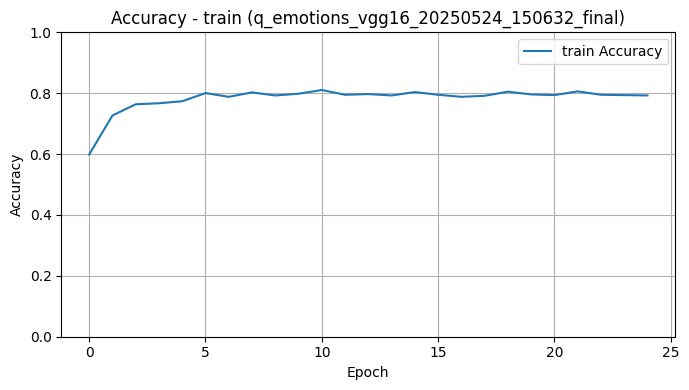

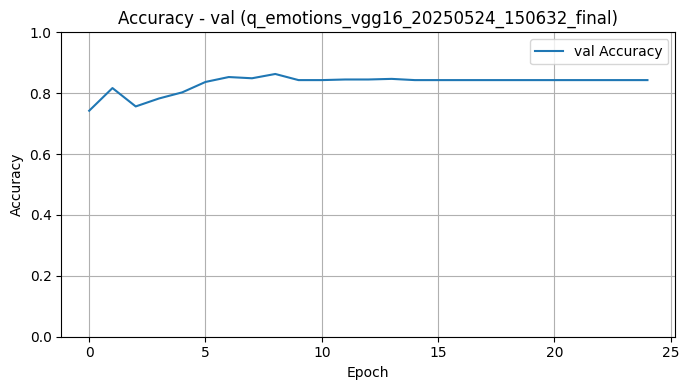

In [142]:
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="val")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="val")

# plot_tensorboard_metric("q_emotions_resnet18_20250516_173726", metric="Loss", phase="val")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="train")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="val")

In [143]:
model_name = "emotions_vgg16_0004_SA_86_5step"
save_model(model_hybrid, quantum=quantum, name=model_name)

💾 Modelo guardado en: models\q_emotions_vgg16_0004_SA_86_5step.pt
